# Input Impedance Properties of the Model
    > Characterizing the parameter dependency of the input impedance spatial profile 


In [1]:
from single_cell_integration import * # code to run the model: (see content below)

import sys
sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt

### Locations where to simulate/record along the dendritic tree

Text(0.5, 1.0, 'n=81 segments')

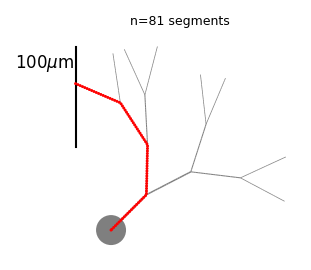

In [2]:
from nrn.plot import nrnvyz
Model = load_params('BRT-parameters.json')
BRT, neuron = initialize(Model)
SEGMENTS = nrn.morpho_analysis.compute_segments(BRT)

vis = nrnvyz(SEGMENTS)
n, N = Model['nseg_per_branch'], Model['branch-number']
#BRANCH_LOCS = np.concatenate([np.arange(n+1),
#                              1+20*N+np.arange(3*n)])
BRANCH_LOCS = np.arange(n*N+1)
fig, ax = pt.plt.subplots(1, figsize=(2,2))
vis.plot_segments(ax=ax, color='tab:grey')
vis.add_dots(ax, BRANCH_LOCS, 2)
ax.set_title('n=%i segments' % len(BRANCH_LOCS), fontsize=6)

### Run Input Impedance Profile Characterization

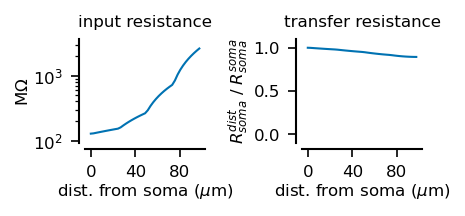

In [3]:
# function to test the spatial-dep
def run_imped_charact(Model,
                      pulse={'amp':1,
                             'duration':200}):
    """
    loop over dendritic locations on the morphology
    
    current in pA, durations in ms
    """

    output = {'loc':[],
              'input_resistance':[],
              'transfer_resistance_to_soma':[]}

    net, BRT, neuron = initialize(Model, with_network=True)
   
    Nseg_tot = Model['nseg_per_branch']*Model['branch-number']+1
    for b in np.arange(Nseg_tot):
        
        net.restore('start')
        
        # recording
        Ms = nrn.StateMonitor(neuron, ('v'), record=[0, b]) # soma + dend loc
        net.add(Ms)
        
        # run a pre-period for relaxation
        net.run(100*nrn.ms)
        
        # turn on the current pulse
        neuron.I[b] = pulse['amp']*nrn.pA
        # run until relaxation (long pulse)
        net.run(pulse['duration']*nrn.ms)
        # turn off the current pulse
        neuron.I[b] = 0*nrn.pA

        # measure all quantities
        output['input_resistance'].append(\
                1e6*(neuron.v[b]-Model['EL']*nrn.mV)/nrn.volt/pulse['amp']) # 1e6*V/pA = MOhm
        output['transfer_resistance_to_soma'].append(\
                1e6*(neuron.v[0]-Model['EL']*nrn.mV)/nrn.volt/pulse['amp']) # 1e6*V/pA = MOhm
        output['loc'].append(b/Nseg_tot*Model['tree-length'])

        net.remove(Ms)
        Ms = None
        
    net.remove(neuron)
    net, BRT, neuron = None, None, None
    return output

def plot(results):

    fig, AX = plt.subplots(1, 2, figsize=(3, 0.9))
    plt.subplots_adjust(wspace=0.8, left=0.15)

    #AX[0].annotate(title, (-0.7, 0.5), rotation=90, xycoords='axes fraction', va='center')
    AX[0].set_title('input resistance')
    AX[1].set_title('transfer resistance')

    AX[0].plot(results['loc'], results['input_resistance'])
    AX[1].plot(results['loc'],
               np.array(results['transfer_resistance_to_soma'])/results['transfer_resistance_to_soma'][0])
               #np.array(results['transfer_resistance_to_soma']))

    pt.set_plot(AX[0], xlabel='dist. from soma ($\mu$m)', yticks=[1e2, 1e3],
                ylabel='M$\Omega$', yscale='log', xticks=np.arange(3)*100)
    pt.set_plot(AX[1], xlabel='dist. from soma ($\mu$m)',
                ylim=[0,1.1], yticks=np.arange(3)*0.5, xticks=np.arange(3)*100,
                ylabel='$R^{dist}_{soma}$ / $R_{soma}^{soma}$')

    return fig

results = run_imped_charact(Model)
fig = plot(results)

In [5]:
import copy

def run_params_scan(key, values):
    Model = load_params('BRT-parameters.json')
    RESULTS = []
    for i, value in enumerate(values):
        cModel = copy.deepcopy(Model)
        cModel[key] = value
        RESULTS.append(run_imped_charact(cModel))
    np.save('../data/%s-impact.npy' % key,
            {key:values, 'results':RESULTS})

def plot_parameter_variation(key,
                             title='title', 
                             label='label',
                             yscale='log'):

    data = np.load('../../data/%s-impact.npy' % key, allow_pickle=True).item()

    fig, AX = plt.subplots(1, 2, figsize=(4, 1.3))
    plt.subplots_adjust(wspace=0.6, right=0.8, left=0.15)

    AX[0].annotate(title, (-0.7, 0.5), rotation=90, xycoords='axes fraction', va='center')
    AX[0].set_title('input resistance')
    AX[1].set_title('attenuation factor')

    for i, results in enumerate(data['results']):
        color = plt.cm.viridis_r(i/(len(data[key])-1))
        AX[0].plot(results['loc'], results['input_resistance'], color=color, lw=1.5)
        AX[1].plot(results['loc'],
                   np.array(results['transfer_resistance_to_soma'])/results['transfer_resistance_to_soma'][0], 
                   color=color, lw=1.5)

    pt.set_plot(AX[0], xlabel='dist. from soma ($\mu$m)', ylabel='M$\Omega$', yscale=yscale)
    pt.set_plot(AX[1], xlabel='dist. from soma ($\mu$m)', ylabel='norm. transfer res.', ylim=[-.1,1.1])

    inset = pt.inset(AX[1], (1.4, 0.0, 0.1, 1.0))
    pt.bar_legend(fig, X=range(len(data[key])+1),
                  ticks = np.arange(len(data[key]))+0.5,
                  ticks_labels = [str(k) for k in data[key]],
                  colormap=plt.cm.viridis_r, ax_colorbar=inset,
                  label=label)

    return fig

## Impact of Branching+Tapering

In [7]:
run_params_scan('branch-number', [1,2,3,4])

In [ ]:
fig = plot_parameter_variation('branch-number',
                               title='Branching',
                               label='branch\nnumber')

In [7]:
run_params_scan('branch-number', [1,2,3,4])

In [ ]:
# figure for paper
key='branch-number'
data = np.load('../../data/%s-impact.npy' % key, allow_pickle=True).item()

fig, AX = pt.plt.subplots(2, figsize=(0.9, 1.6))
pt.plt.subplots_adjust(hspace=0.15, right=0.8, left=0.15)

for i, results in enumerate(data['results']):
    color = pt.viridis_r(i/(len(data[key])-1))
    AX[0].plot(results['loc'], results['input_resistance'], color=color, lw=1.5)
    AX[1].plot(results['loc'], 
               np.array(results['transfer_resistance_to_soma'])/results['transfer_resistance_to_soma'][0],
               color=color, lw=1.5)

pt.set_plot(AX[0], xticks=[0,100,200], yscale='log', yticks=[1e2,1e3], #ylim=[90, 9700], 
            xticks_labels=[])
pt.set_plot(AX[1], xticks=[0,100,200], xlabel='dist. from soma ($\mu$m)', 
            ylim=[0.3, 1.1], 
            yticks=0.4+np.arange(3)*0.3, 
            yscale='lin')

inset = pt.inset(AX[1], (1.4, 0.5, 0.1, 0.8))
pt.bar_legend(fig, X=range(len(data[key])+1),
              ticks = np.arange(len(data[key]))+0.5,
              ticks_labels = [str(k) for k in data[key]],
              colormap=pt.viridis_r, ax_colorbar=inset,
              label='branch number')
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'fig.svg'))

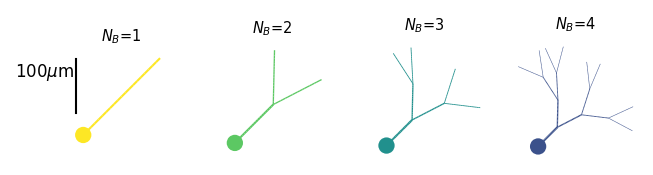

In [7]:
BRANCHES = [1,2,3,4]
fig, AX = plt.subplots(1, len(BRANCHES), figsize=(5, 1.5))

for i, N in enumerate(BRANCHES):
    BRT = nrn.morphologies.BallandRallsTree.build_morpho(\
                                    Nbranch=N,
                                    branch_length=1.0*Model['tree-length']/N,
                                    soma_radius=Model['soma-radius'],
                                    root_diameter=Model['root-diameter'],
                                    Nperbranch=Model['nseg_per_branch'])

    SEGMENTS = nrn.morpho_analysis.compute_segments(BRT)

    vis = nrnvyz(SEGMENTS)
    BRANCH_LOCS = np.arange(Model['nseg_per_branch']*Model['branch-number']+1)
    vis.plot_segments(ax=AX[i], color=plt.cm.viridis_r(i/4),
                      bar_scale_args={'Ybar':100,'Ybar_label':'100$\\mu$m ','Xbar': 1e-10} if i==0 else\
                             {'Ybar':1e-10,'Xbar': 1e-10})
    AX[i].set_title('$N_B$=%i' % N, fontsize=7)
pt.set_common_xlims(AX)
#fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'fig.svg'))

## Impact of Tapering (diameter reduction rule)

In [ ]:
run_params_scan('diameter-reduction-factor', [0.6, 0.7, 0.8, 0.9, 1.0])

In [ ]:
fig = plot_parameter_variation('diameter-reduction-factor',
                               title='Tapering',
                               label='tapering factor')

## Impact of Tree Length

In [ ]:
run_params_scan('tree-length', [50, 100, 200, 400])

In [ ]:
fig = plot_parameter_variation('tree-length',
                               title='Tree Length',
                               label='full length\n($\\mu$m)')

## Impact of Intracellular Resistance

In [ ]:
run_params_scan('Ri', [50, 100, 150, 200, 300])

In [ ]:
fig = plot_parameter_variation('Ri',
                               title='   Intracellular Resistivity',
                               label='$R_i$\n($\Omega$.cm)')

## Impact of Transmembrane Resistance

In [ ]:
run_params_scan('gL', [0.25, 0.5, 1, 2.5, 5])

In [ ]:
fig = plot_parameter_variation('gL',
                               title='Membrane Conductance',
                               label='$g_L$\n(pS/$\\mu$m$^2$)')

## Impact of Root Diameter

In [ ]:
run_params_scan('root-diameter', [0.6, 0.8, 1, 1.5, 2])

In [ ]:
fig = plot_parameter_variation('root-diameter',
                               title='Tree Root Diameter',
                               label='root diam.\n($\\mu$m)')

## Impact of Soma Size

In [ ]:
run_params_scan('soma-radius', [2, 5, 10, 20, 50])

In [ ]:
fig = plot_parameter_variation('soma-radius',
                               title='Soma Size',
                               label='soma radius ($\\mu$m)')

## Summary Fig

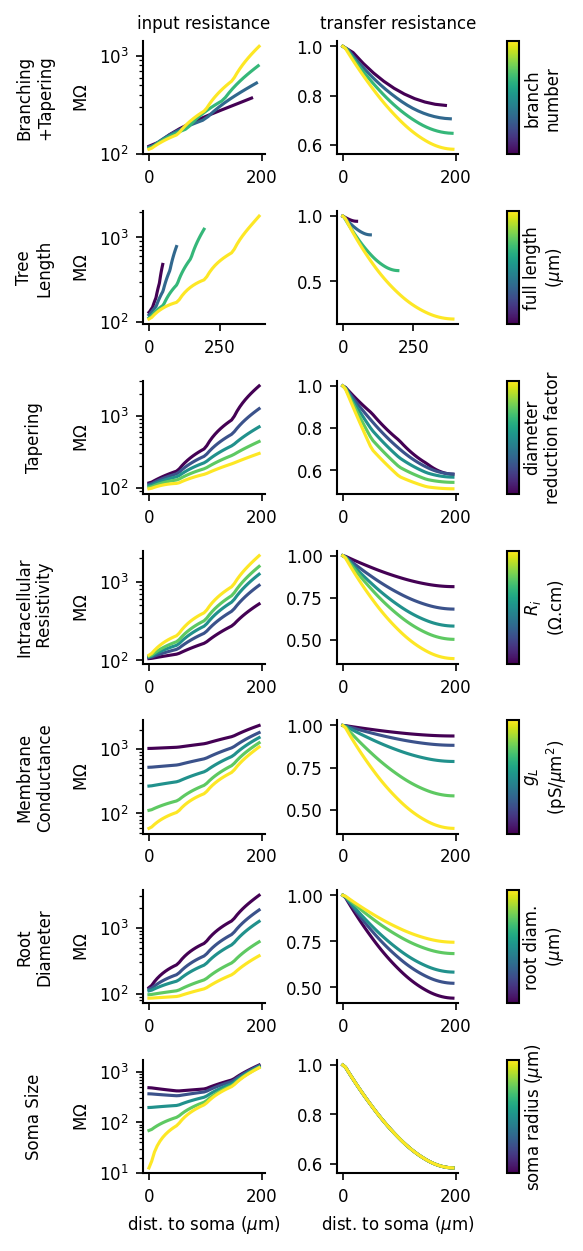

In [19]:
KEYS = [\
    'branch-number',
    'tree-length',
    'diameter-reduction-factor',
    'Ri',
    'gL',
    'root-diameter',
    'soma-radius']

TITLES = [\
    'Branching\n+Tapering',
    'Tree\nLength',
    'Tapering',
    'Intracellular\n Resistivity',
    'Membrane\nConductance',
    'Root\nDiameter',
    'Soma Size']

LABELS=[\
    'branch\nnumber',
    'full length\n($\\mu$m)',
    'diameter\nreduction factor',
    '$R_i$\n($\Omega$.cm)',
    '$g_L$\n(pS/$\\mu$m$^2$)',
    'root diam.\n($\\mu$m)',
    'soma radius ($\\mu$m)']

N = len(KEYS)
fig, AXS = plt.subplots(N, 2, figsize=(3.5, 1.4*N))
plt.subplots_adjust(wspace=0.6, hspace=0.5, right=0.8, left=0.2)

AXS[0][0].set_title('input resistance')
AXS[0][1].set_title('transfer resistance')

for key, title, label, AX in zip(KEYS, TITLES, LABELS, AXS):

    data = np.load('../../data/%s-impact.npy' % key, allow_pickle=True).item()

    AX[0].annotate(title, (-0.9, 0.5), rotation=90, xycoords='axes fraction',
                   va='center', ha='center')


    for i, results in enumerate(data['results']):
        color = plt.cm.viridis(i/(len(data[key])-1))
        AX[0].plot(results['loc'], results['input_resistance'], color=color, lw=1.5)
        AX[1].plot(results['loc'], np.array(results['transfer_resistance_to_soma'])/results['transfer_resistance_to_soma'][0], color=color, lw=1.5)

    inset = pt.inset(AX[1], (1.4, 0.0, 0.1, 1.0))
    pt.bar_legend(fig, 
                  #X=range(len(data[key])+1),
                  #ticks = np.arange(len(data[key]))+0.5,
                  #ticks_labels = [str(k) for k in data[key]],
                  colormap=plt.cm.viridis, ax_colorbar=inset,
                  label=label)
    AX[0].set_ylabel('M$\Omega$')
    AX[0].set_yscale('log')
    for ax in AX:
        if key==KEYS[-1]:
            ax.set_xlabel('dist. to soma ($\mu$m)')

#fig.savefig('../figures/Ball-and-Rall-Tree-parameters.svg')